In [1]:
# * Load in the nwb file and inspect
import pynapple as nap
import h5py

# file = "test.nwb"

# data = nap.load_file(file)
data = h5py.File("test.nwb", "r")
x = data['units']['spike_times']
x

<HDF5 dataset "spike_times": shape (106865773,), type "<f8">

In [2]:
import numpy as np
class LazySpikeLoader():
    def __init__(self, nwb_file):
        self.data = h5py.File(nwb_file, "r")
        self.spikes = self.data['units']['spike_times']
        self.units = self.data['units']['id']
        self.indices = self.data['units']['spike_times_index']

    # def __getitem__(self, key):
    #     return self.spikes[self.indices[key]:self.indices[key+1]]

    # def __iter__(self):
    #     for unit in self.units:
    #         yield self[unit]

    # def __len__(self):
    #     return len(self.units)

    def __del__(self):
        self.data.close()

    def batch(self, start_time, end_time):
        # * Get the spike times within the given time range for each unit
        # * Search sorted over the memory-mapped self.spikes vector
        spike_times = []
        for i in range(len(self.units)):
            start_idx = self.indices[i]
            if i == len(self.units) - 1:
                end_idx = self.spikes.shape[0]
            else:
                end_idx = self.indices[i+1] # Assumes the spike_time_indices are correctly ordered
            neuron_spikes = self.spikes[start_idx : end_idx]
            left = np.searchsorted(neuron_spikes, start_time, side='left')
            right = np.searchsorted(neuron_spikes, end_time, side='right')
            batch_spikes = neuron_spikes[left:right]
            spike_times.append(batch_spikes)
        return spike_times

spikes = LazySpikeLoader("test.nwb")


In [3]:
x = spikes.spikes[:]

In [4]:
spikes.batch(100, 200) # How does this compare to loading the full file?

[array([110.23387256, 121.63463359, 130.02102062, 130.57772197,
        130.58835533, 130.6700222 , 130.8753227 , 131.04085643,
        131.13068998, 131.18085677, 131.29329038, 131.32159045,
        131.45459077, 131.55812436, 131.57002438, 131.62512452,
        131.67865798, 131.69229135, 131.72092475, 131.73789146,
        131.76022485, 131.76182485, 131.82995835, 131.85899175,
        131.87212512, 131.95549199, 132.00642544, 132.00765878,
        132.10122567, 132.1673925 , 132.20509259, 132.25105937,
        132.25962606, 132.31709287, 132.39705973, 132.39732639,
        132.39745973, 132.42199312, 132.42229312, 132.42325979,
        132.4409265 , 132.44105983, 132.44215984, 132.45492653,
        132.46572656, 132.49425996, 132.50629333, 132.50652666,
        132.55629345, 132.55652678, 132.58519352, 132.58539352,
        132.58582685, 132.6187936 , 132.61996027, 132.6332603 ,
        132.65196035, 132.68232709, 132.68569376, 132.72176052,
        132.72192718, 132.72212718, 132.

In [5]:
# * Load neuron by neuron and compute the bin counts
data = h5py.File("test.nwb", "r")
x = data['units']['spike_times']


In [ ]:
import jax.numpy as jnp
import jax
from tqdm import tqdm
from functools import partial

@partial(jax.jit, static_argnames=['dtype'])
def jax_count(spike_times, bin_edges, dtype=jnp.uint32):
    num_bins = bin_edges.size - 1
    idx = jnp.searchsorted(bin_edges, spike_times, side="right") - 1
    counts = jnp.bincount(idx, length=num_bins)

    return jax.lax.convert_element_type(counts, dtype)

def nwb_spike_count(file, interval, window, batchsize=None, dtype=jnp.uint32, save=False):
    T = interval[1] - interval[0]
    N = int(T // window)
    if save:
        readmode = "a"
    else:
        readmode = "r"
    with h5py.File(file, readmode) as data:
        spike_times = data['units']['spike_times'][:] # * [:] Loads the entire file at once
        units = len(data['units']['id'])
        indices = data['units']['spike_times_index']

        bin_edges = jnp.linspace(interval[0]-window, interval[1], N + 2) # Add an extra bin to count less-than spikes

        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        def indices2idxs(i):
            minidx = indices[i]
            maxidx = indices[i+1] if i < units - 1 else len(spike_times)
            return range(minidx, maxidx)

        if batchsize is not None:
            nbatches = np.ceil(units / batchsize)
        else:
            nbatches = 1

        batchis = np.arange(units)
        batchis = np.array_split(batchis, nbatches)

        @jax.jit
        def _count(spike_times):
            return jax_count(spike_times, bin_edges, dtype)

        def count(batchi):
            # * Get spike times for a batch
            batch = [spike_times[indices2idxs(i)] for i in batchi]

            # * Pad the batch with NaN's for JaX
            maxlen = max([len(b) for b in batch])
            batch = [jnp.pad(b, (0, maxlen - len(b)), constant_values=np.nan) for b in batch]
            batch = jnp.stack(batch)

            counts = jax.vmap(_count)(batch)
            return counts

        if save:
            if 'counts' in data:
                del data['counts']
            if 'bin_centers' in data:
                del data['bin_centers']
            data.create_dataset("counts", data=np.zeros((units, N), dtype=dtype))
            for batchi in tqdm(batchis):
                counts_batch = count(batchi)
                data["counts"][batchi, :] = counts_batch[:, 1:]
            data.create_dataset("bin_centers", data=np.array(bin_centers[1:]))
            return file
        else:
            X = jnp.concatenate([count(batchi) for batchi in tqdm(batchis)], axis=0)
            return X[:, 1:], bin_centers[1:]


In [ ]:
file = nwb_spike_count("test copy 2.nwb", (0, 9600), 0.005, batchsize=1000, dtype=jnp.uint8, save=True) # How does this compare to loading the full file?

100%|██████████| 3/3 [01:14<00:00, 24.76s/it]


: 

In [189]:
with h5py.File(file, "r") as data:
    x = data['counts'][:]
    bin_centers = data['bin_centers'][:]
    print(x.shape)
    print(bin_centers.shape)
    print(x.dtype)
    print(bin_centers.dtype)

(2005, 19199)
(19199,)
uint8
float32


(10.0, 50.0)

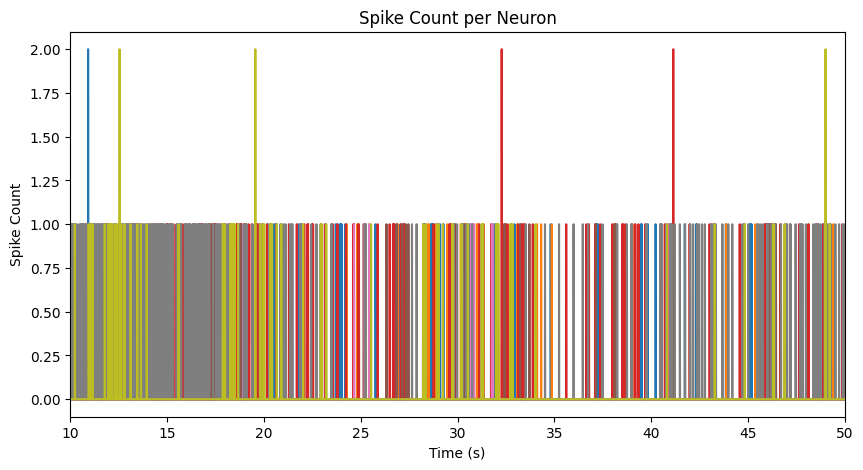

In [190]:
# Plot results
import matplotlib.pyplot as plt

# * Plot each neurons count trace
plt.figure(figsize=(10, 5))
for i in range(x.shape[0])[1:10:]:
    plt.plot(bin_centers, x[i], label=f"Neuron {i}")
plt.xlabel("Time (s)")
plt.ylabel("Spike Count")
plt.title("Spike Count per Neuron")
plt.gca().set_xlim(10, 50)

In [8]:
file = "test.nwb"
data = nap.load_file(file)
x = data

/headnode2/bhar9988/code/COSYNE2025_hackathon/.conda/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [9]:
%load_ext line_profiler
# Benchmark pynapple counts
units = x['units']
units.count(5)
%lprun -f nap.TsGroup.count units.count(5)

/headnode2/bhar9988/code/COSYNE2025_hackathon/.conda/lib/python3.12/site-packages/pynapple/core/base_class.py:51: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/headnode2/bhar9988/code/COSYNE2025_hackathon/.conda/lib/python3.12/site-packages/pynapple/core/base_class.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Timer unit: 1e-09 s

Total time: 0.688539 s
File: /headnode2/bhar9988/code/COSYNE2025_hackathon/.conda/lib/python3.12/site-packages/pynapple/core/ts_group.py
Function: count at line 607

Line #      Hits         Time  Per Hit   % Time  Line Contents
   607                                               def count(self, bin_size=None, ep=None, time_units="s", dtype=None):
   608                                                   """
   609                                                   Count occurences of events within bin_size or within a set of bins defined as an IntervalSet.
   610                                                   You can call this function in multiple ways :
   611                                           
   612                                                   1. *tsgroup.count(bin_size=1, time_units = 'ms')*
   613                                                   -> Count occurence of events within a 1 ms bin defined on the time support of the object.
   614   

In [10]:
import jax
import jax.numpy as jnp
import pynapple as nap

@jax.jit
def jax_count(spike_times, bin_edges):
    num_bins = bin_edges.size - 1
    time_index = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    sorted_times = jnp.sort(spike_times)
    idx = jnp.searchsorted(bin_edges, sorted_times, side="right") - 1
    counts = jnp.bincount(idx, length=num_bins)

    return time_index, counts

@jax.jit
def jax_count_tsd(tsd, bin_edges):
    spike_times = tsd.times()
    return jax_count(spike_times, bin_edges)

def jax_count_tsg(spike_times, bin_edges):
    jax.tree.map(jax_count_tsd, spike_times)

In [11]:
x = data['units'][1068218147]

spike_times = x.times()
interval = jnp.asarray([0, 10000])
num_bins = jnp.diff(interval)[0]//10
bin_edges = jnp.linspace(interval[0], interval[1], num_bins + 1)


time_index, counts = jax_count_tsd(x, bin_edges)

TypeError: Error interpreting argument to <function jax_count_tsd at 0x152491d14220> as an abstract array. The problematic value is of type <class 'pynapple.core.time_series.Ts'> and was passed to the function at path tsd.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

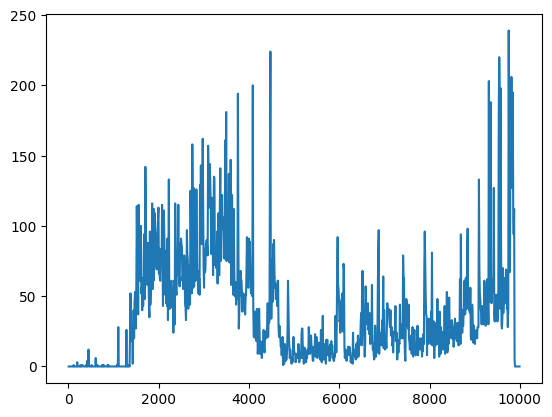

In [ ]:
# * Plot the counts over time
import matplotlib.pyplot as plt
plt.plot(time_index, counts)
plt.show()

In [ ]:
# * For Tsg
x = data['units'].data
# jax_count_tsg(x.data, bin_edges)
# jax_count_tsd(, bin_edges)
# x[1068218147]

Time (s)
113.872748066
195.391746067
195.731613559
199.309755583
266.393751856
308.452987346
319.507447529
...
9879.918868666
9879.957202092
9880.026168927
9880.072169038
9880.107769125
9880.142902544
9880.228502751
shape: 39480

In [ ]:
import jax.numpy as jnp
import pynapple as nap
import pynapple: IntervalSet, TsIndex, TsGroup, TsdFrame
def jax_count(self, bin_size=None, ep=None, time_units="s", dtype=None):
    if bin_size is not None:
        if isinstance(bin_size, int):
            bin_size = float(bin_size)
        if not isinstance(bin_size, float):
            raise TypeError("bin_size argument should be float or int.")

    if not isinstance(time_units, str) or time_units not in ["s", "ms", "us"]:
        raise ValueError("time_units argument should be 's', 'ms' or 'us'.")

    if ep is None:
        ep = self.time_support
    if not isinstance(ep, IntervalSet):
        raise TypeError("ep argument should be of type IntervalSet")

    if dtype is None:
        dtype = np.dtype(np.int64)
    else:
        try:
            dtype = np.dtype(dtype)
        except Exception:
            raise ValueError(f"{dtype} is not a valid numpy dtype.")

    starts = ep.start
    ends = ep.end

    if isinstance(bin_size, (float, int)):
        bin_size = TsIndex.format_timestamps(np.array([bin_size]), time_units)[0]

    # Call it on first element to pre-allocate the array
    if len(self) >= 1:
        time_index, d = _count(
            self.data[self.index[0]].index.values,
            starts,
            ends,
            bin_size,
            dtype=dtype,
        )

        count = np.zeros((len(time_index), len(self.index)), dtype=dtype)
        count[:, 0] = d

        for i in range(1, len(self.index)):
            count[:, i] = _count(
                self.data[self.index[i]].index.values,
                starts,
                ends,
                bin_size,
                dtype=dtype,
            )[1]

        return TsdFrame(t=time_index, d=count, time_support=ep, columns=self.index)
    else:
        time_index, _ = _count(np.array([]), starts, ends, bin_size, dtype=dtype)
        return TsdFrame(
            t=time_index, d=np.empty((len(time_index), 0)), time_support=ep
        )



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import nemos as nmo

nap.nap_config.suppress_conversion_warnings = True

# set random seed
np.random.seed(123)


In [ ]:
n_neurons = 10
T = 50

times = np.linspace(0, T, 5000).reshape(-1, 1)
rate = np.exp(np.sin(times + np.linspace(0, np.pi*2, n_neurons).reshape(1, n_neurons)))


spike_t, spike_id = np.where(np.random.poisson(rate))
units = nap.Tsd(spike_t/T, spike_id).to_tsgroup()



In [ ]:
glm = nmo.glm.PopulationGLM(
	solver_name="GradientDescent",
	solver_kwargs={"stepsize": 0.1, "acceleration": False}
	)
ws = 40
basis = nmo.basis.RaisedCosineLogConv(5, window_size=ws)


batch_size = 5  # second

def batcher():
	# Grab a random time within the time support. Here is the time support is one epoch only so it's easy.
	t = np.random.uniform(units.time_support[0, 0], units.time_support[0, 1]-batch_size)

	# Bin the spike train in a 1s batch
	ep = nap.IntervalSet(t, t+batch_size)
	counts = units.restrict(ep).count(0.005)  # count in 5 ms bins

	# Convolve
	X = basis.compute_features(counts)

	# Return X and counts
	return X, counts

params = glm.initialize_params(*batcher())
state = glm.initialize_state(*batcher(), params)

n_step = 5000
logl = np.zeros(n_step)

for i in range(n_step):

	# Get a batch of data
	X, Y = batcher()

	# Do one step of gradient descent.
	params, state = glm.update(params, state, X, Y)

	# Score the model along the time axis
	logl[i] = glm.score(X, Y, score_type="log-likelihood")


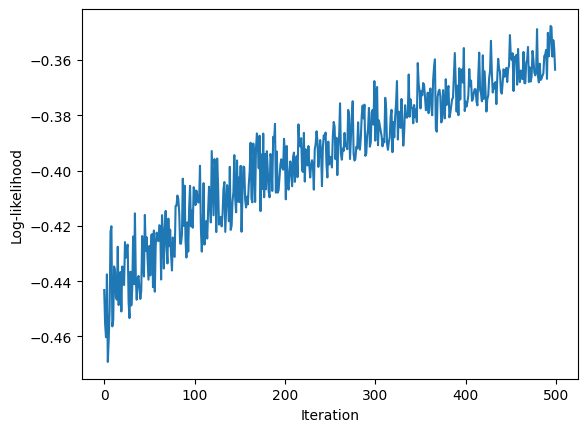

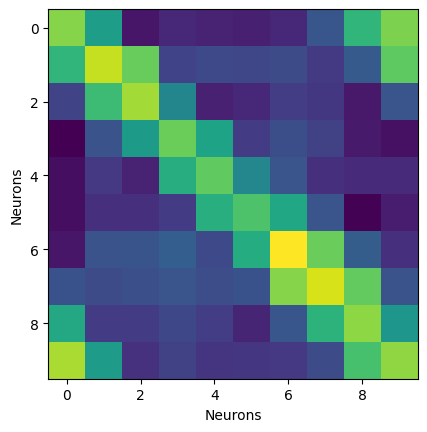

In [ ]:
fig = plt.figure()
plt.plot(logl)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()

# save image for thumbnail
from pathlib import Path
import os

root = os.environ.get("READTHEDOCS_OUTPUT")
if root:
   path = Path(root) / "html/_static/thumbnails/how_to_guide"
# if local store in ../_build/html/...
else:
   path = Path("../_build/html/_static/thumbnails/how_to_guide")

# make sure the folder exists if run from build
if root or Path("../assets/stylesheets").exists():
   path.mkdir(parents=True, exist_ok=True)

if path.exists():
  fig.savefig(path / "plot_04_batch_glm.svg")


W = glm.coef_.reshape(len(units), basis.n_basis_funcs, len(units))
Wm = np.mean(np.abs(W), 1)

# Let's plot it.

plt.figure()
plt.imshow(Wm)
plt.xlabel("Neurons")
plt.ylabel("Neurons")
plt.show()


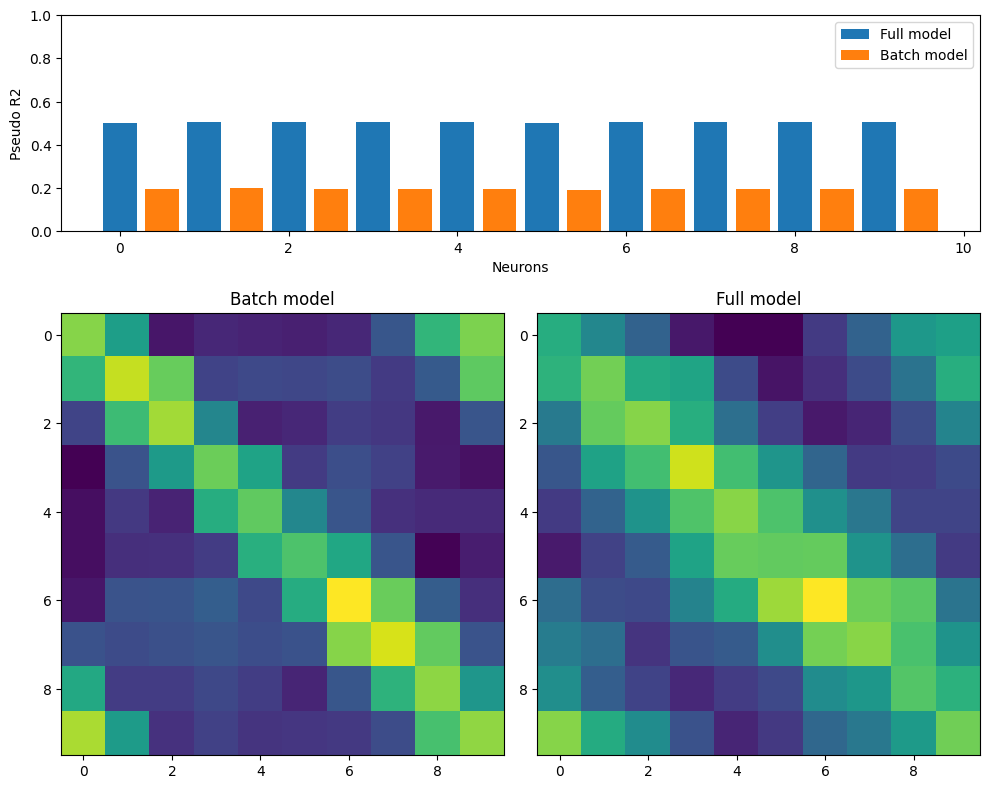

In [ ]:
Y = units.count(0.005)
X = basis.compute_features(Y)
full_model = nmo.glm.PopulationGLM().fit(X, Y)

full_scores = full_model.score(
	X, Y, aggregate_sample_scores=lambda x:np.mean(x, axis=0), score_type="pseudo-r2-McFadden"
)
batch_scores = glm.score(
	X, Y, aggregate_sample_scores=lambda x:np.mean(x, axis=0), score_type="pseudo-r2-McFadden"
)

plt.figure(figsize=(10, 8))
gs = plt.GridSpec(3,2)
plt.subplot(gs[0,:])
plt.bar(np.arange(0, n_neurons), full_scores, 0.4, label="Full model")
plt.bar(np.arange(0, n_neurons)+0.5, batch_scores, 0.4, label="Batch model")
plt.ylabel("Pseudo R2")
plt.xlabel("Neurons")
plt.ylim(0, 1)
plt.legend()
plt.subplot(gs[1:,0])
plt.imshow(Wm)
plt.title("Batch model")
plt.subplot(gs[1:,1])
Wm2 = np.mean(
	np.abs(
		full_model.coef_.reshape(len(units), basis.n_basis_funcs, len(units))
		)
	, 1)
plt.imshow(Wm2)
plt.title("Full model")
plt.tight_layout()
plt.show()
